In [1]:
import pandas as pd
import numpy as np

import keras

# plot libraries
%matplotlib inline
import matplotlib.pyplot as plt

# system libraries
from os.path import join

# image load libraries
from data_util import load_image, get_patch

/home/pablo/anaconda3/envs/MLiP/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Generator

In [2]:
class PatchGenerator(object):

    def __init__(self, input_dir, dataframe, batch_size, res = 'v', augmentation_fn = None):

        # params
        self.input_dir       = input_dir        # path to patches in global format
        self.batch_size      = batch_size       # number of patches per batch
        self.res             = res              # resolution to use "low" or "high"        
        self.augmentation_fn = augmentation_fn  # augmentation function
        self.df              = dataframe        # dataframe
        
        # info
        self.n_samples = len(self.df)
        self.n_batches = self.n_samples // self.batch_size
        
        # print some info
        print('PatchGenerator detected: {n_samples} patch samples.'.format(n_samples = self.n_samples))

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # provide length in number of batches
        return self.n_batches

    def next(self):
        
        # randomly sample 1/3 of class 2 (tumor)
        df_2 = self.df.loc[self.df['histology'] == '2', :].sample(self.batch_size//3, replace = True)
        
        # randomly sample 1/3 of class 20 (fiber)
        df_20 = self.df.loc[self.df['histology'] == '20', :].sample(self.batch_size//3, replace = True)
        
        # randomly sample of size rest (class 21 cyst) to complete the batch 
        rest = self.batch_size - (len(df_2) + len(df_20))
        df_21 = self.df.loc[self.df['histology'] == '21', :].sample(rest, replace = True)
        
        # concatenate 3 clases sample dataframes
        df_batch = pd.concat([df_2, df_20, df_21])
                
        # iterate over selected images
        images = []
        labels = []
        for index, row in df_batch.iterrows():
            
            try:
                
                # read data and label
                pID = row['patientID']
                sID = row['studyID']
                sNa = row['scanName']
                
                # load the full image
                image_full = load_image(patient_id = pID,
                                        study_id   = sID,
                                        scan_name  = sNa, 
                                        datadir    = self.input_dir, 
                                        res        = self.res)

                label = row['histology']

                # obtain coordinates (y,x,z)
                if self.res is 'v':
                    coordinates = (int(row['annotationLowResolution1']),
                                   int(row['annotationLowResolution2']),
                                   int(row['annotationLowResolution3']))
                else:
                    coordinates = (int(row['annotationHighResolution1']),
                                   int(row['annotationHighResolution2']),
                                   int(row['annotationHighResolution3']))
                                
                # load the desired patch
                image = get_patch(image_full, coordinates, size = 40)
                                
                # data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # append image and labels
                images.append(image)
                
                # one hot enconding labels
                if label == '2':
                    labels.append((0, 0, 1))
                elif label == '21':
                    labels.append((0, 1, 0))
                else:
                    labels.append((1, 0, 0))
                
            except Exception as e:
                print('Failed reading idx {idx}...'.format(idx = index))
                print(e)

        # assemble batch            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, batch_y

PatchGenerator detected: 298 patch samples.
Failed reading idx 196...
Exception thrown in SimpleITK ReadImage: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:89:
sitk::ERROR: The file "./data/train/02002173/st01/v0200217301ar.mhd" does not exist.


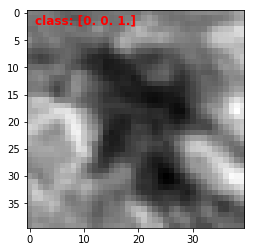

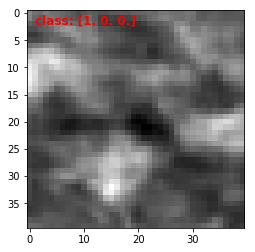

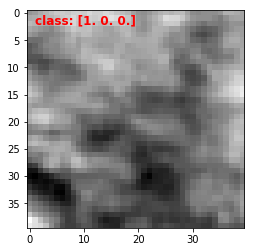

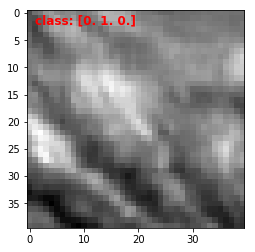

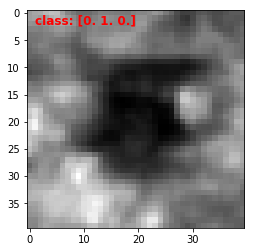

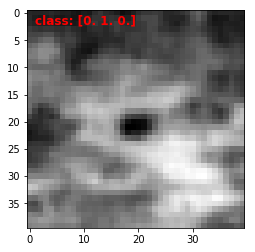

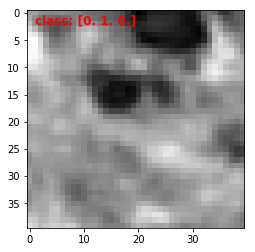

In [7]:
# test the data generator
training_gen = PatchGenerator(
    input_dir = './data',
    dataframe = pd.read_csv(join('./data', 'trainingSet.csv'), dtype=str),
    batch_size = 8
)

# test the batch generator
for batch_x, batch_y in training_gen:
    for i in range(len(batch_x)):
        plt.figure()
        plt.imshow(batch_x[i][:,:,len(batch_x[i])//2,0], cmap='gray')
        plt.text(1, 2, 'class: ' + str(batch_y[i]), fontdict={'color': 'r',
                                                              'size': 'large',
                                                              'weight': 'bold',
                                                             })
    break

## PatchSequence

In [8]:
class PatchSequence(keras.utils.Sequence):

    def __init__(self, input_dir, dataframe, batch_size, res = 'v'):

        # params
        self.input_dir  = input_dir   # path to patches in glob format
        self.df         = dataframe   # dataframe
        self.batch_size = batch_size  # number of patches per batch
        self.res        = res         # resolution
        
        # length
        self.n_samples = len(self.df)
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('PatchSequence detected: {n_samples} patch samples.'.format(n_samples=len(self.df)))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def get_all_labels(self):
        return self.df.loc[:, 'label'].values
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        labels = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                
                # get the row
                row = self.df.iloc[i, :]
                
                # read data and label
                pID = row['patientID']
                sID = row['studyID']
                sNa = row['scanName']
                
                # load the full image
                image_full = load_image(patient_id = pID,
                                        study_id   = sID,
                                        scan_name  = sNa, 
                                        datadir    = self.input_dir, 
                                        res        = self.res)

                label = row['histology']
                
                # obtain coordinates (y,x,z)
                if self.res is 'v':
                    coordinates = (int(row['annotationLowResolution1']),
                                   int(row['annotationLowResolution2']),
                                   int(row['annotationLowResolution3']))
                else:
                    coordinates = (int(row['annotationHighResolution1']),
                                   int(row['annotationHighResolution2']),
                                   int(row['annotationHighResolution3']))
                                
                # load the desired patch
                image = get_patch(image_full, coordinates, size = 40)
                 
                # append image and labels
                images.append(image)
                
                # one hot enconding labels
                if label == '2':
                    labels.append((0, 0, 1))
                elif label == '21':
                    labels.append((0, 1, 0))
                else:
                    labels.append((1, 0, 0))
                
            except Exception as e:
                print('Failed reading idx {idx}...'.format(idx=i))
                print(e)

        # Assemble batch            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, batch_y

PatchSequence detected: 298 patch samples.
Failed reading idx 3...
Exception thrown in SimpleITK ReadImage: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:89:
sitk::ERROR: The file "./data/train/02002243/st01/v0200224301mr.mhd" does not exist.
Failed reading idx 4...
Exception thrown in SimpleITK ReadImage: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:89:
sitk::ERROR: The file "./data/train/02002287/st07/v0200228707al.mhd" does not exist.


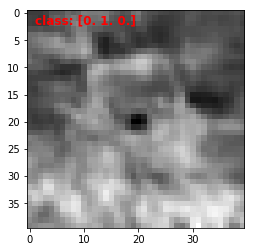

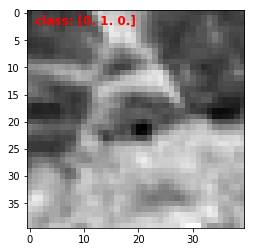

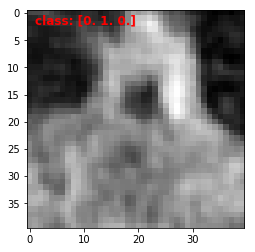

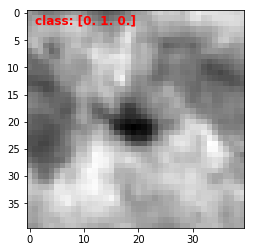

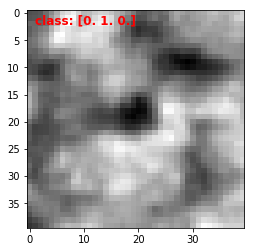

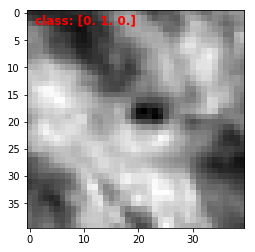

In [10]:
# test the patch sequence
validation_gen = PatchSequence(
    input_dir = './data',
    dataframe = pd.read_csv(join('./data', 'trainingSet.csv'), dtype=str),
    batch_size = 8
)

# test the batch generator
for batch_x, batch_y in validation_gen:
    for i in range(len(batch_x)):
        plt.figure()
        plt.imshow(batch_x[i][:,:,len(batch_x[i])//2,0], cmap='gray')
        plt.text(1, 2, 'class: ' + str(batch_y[i]), fontdict={'color': 'r',
                                                              'size': 'large',
                                                              'weight': 'bold',
                                                             })
    break